# The 80-Minute Journey: A Data-Driven Analysis of Marathon Progression

**Author:** Aditya Padmarajan
**Dataset:** Strava activity export (Feb 2022 – Oct 2025)  

---

## Project Overview

This notebook analyzes **347 running activities over 3.5 years**, documenting the progression from a first-time marathoner (4:46:07 at Royal Victoria Marathon 2022) to a sub-3:30 finisher (3:26:00 at Royal Victoria Marathon 2025) — an improvement of **80 minutes** across 6 marathon races.

The analysis explores how training patterns, physiological adaptations, and race execution evolved to produce consistent performance gains at two recurring races: the **Royal Victoria Marathon** (4 finishes) and **BMO Vancouver Marathon** (2 finishes).

---

## Datasets

| File | Description | Records |
|------|-------------|---------|
| `activities_dataset.csv` | Complete Strava activity export with pace, HR, elevation, and metadata | 347 activities |
| `global_challenges.csv` | Strava challenge participation history | 699 challenges |

---

## Marathon Race Summary (Official Times)

| Race | Date | Finish Time | Pace | Avg HR |
|------|------|-------------|------|--------|
| Royal Victoria Marathon 2022 | Oct 9, 2022 | 4:46:07 | 6:30/km | 147 bpm |
| BMO Vancouver Marathon 2023 | May 7, 2023 | 4:25:48 | 6:13/km | 160 bpm |
| Royal Victoria Marathon 2023 | Oct 8, 2023 | 4:16:58 | 6:04/km | 161 bpm |
| Royal Victoria Marathon 2024 | Oct 13, 2024 | 3:47:47 | 5:22/km | 162 bpm |
| BMO Vancouver Marathon 2025 | May 4, 2025 | 3:37:23 | 5:07/km | 164 bpm |
| Royal Victoria Marathon 2025 | Oct 12, 2025 | 3:26:00 | 4:50/km | 170 bpm |

---

## Planned Visualizations

### 1. Marathon Progression Timeline
A bar or line chart displaying finish times across all 6 marathons, highlighting the downward trend from 4:46 to 3:26. This serves as the anchor visualization for the entire analysis.

### 2. Pace Evolution Curve
Line chart tracking average pace (min/km) for each marathon with a trend line, demonstrating the progression from 6:30/km to 4:50/km.

### 3. Heart Rate Efficiency Analysis
Scatterplot comparing pace vs. average heart rate across marathons. This visualization reveals aerobic efficiency gains — running faster at similar cardiac output indicates improved fitness.

### 4. Training Volume by Marathon Block
Stacked area or bar chart showing weekly mileage in the 12–16 weeks preceding each marathon. Correlates training load with race-day performance.

### 5. Monthly Running Volume Heatmap
Calendar-style heatmap (similar to GitHub contributions) showing daily/weekly running activity, revealing consistency patterns and training periodization.

### 6. Long Run Progression
Tracks the longest training runs before each marathon, showing how peak long run distance evolved across training cycles.

### 7. Course Comparison: Victoria vs Vancouver
Side-by-side comparison of the two race courses, analyzing elevation profiles, pace distribution, and heart rate response to control for course difficulty.

### 8. Cumulative Distance Over Time
Running total of kilometers logged since February 2022, with marathon race days marked as milestones.

### 9. Elevation vs Pace Relationship
Scatterplot examining how elevation gain impacts average pace across all training runs, useful for understanding performance on hilly courses.

### 10. Challenge Engagement Timeline
Bar chart or heatmap showing monthly Strava challenge completions, illustrating engagement and motivation patterns throughout the training journey.

---

## Key Questions This Analysis Will Answer

1. **What training volume correlates with marathon performance?**  
   Is there a weekly mileage threshold that predicts sub-4:00 or sub-3:30 performance?

2. **How did aerobic efficiency improve?**  
   Can we quantify the pace/HR relationship improvement over time?

3. **What distinguishes Victoria vs Vancouver performances?**  
   Are course-specific factors (elevation, weather) affecting results?

4. **What does the optimal taper look like?**  
   How did training volume change in the final 2–3 weeks before each race?

5. **Is there a long run distance that predicts race success?**  
   What was the longest run before each PR?

---

## Technical Notes

- **Distance** is measured in kilometers
- **Speed** is measured in meters per second (converted to min/km pace for analysis)
- **Time** values are in seconds
- **Heart Rate** data is unavailable for the first 20 runs (Feb–Jun 2022) due to no HR monitor
- **Elevation** is measured in meters

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

## Data Collection

In [2]:
df = pd.read_csv("activities_dataset.csv")
# Filter to running activities FIRST
df2 = df.query("`Activity Type` == 'Run'").reset_index(drop=True)

# Rename columns
df2 = df2.rename(columns={
    "Distance": "Distance (km)",
    "Average Speed": "Avg Speed (m/s)",
    "Max Speed": "Max Speed (m/s)",
    "Moving Time": "Moving Time (s)",
    "Elapsed Time": "Elapsed Time (s)",
    "Average Heart Rate": "Avg HR (bpm)",
    "Max Heart Rate": "Max HR (bpm)",
    "Elevation Gain": "Elevation Gain (m)",
    "Elevation Loss": "Elevation Loss (m)",
    "Elevation High": "Elevation High (m)",
    "Elevation Low": "Elevation Low (m)"
})

## Pre-Processing and Feature Engineering

In [3]:
# Parse dates
# %b -> Abbreviated Month Name (Feb, May, Oct)
# %d -> Day of Month (01-31)
# %Y -> 4-digit year (2022, 2025)
# %I -> Hour (12-hour clock)
# %M -> Minutes (00-59)
# %S -> Seconds (00-59)
# %p -> AM or PM
df2["Activity Date"] = pd.to_datetime(df2["Activity Date"], format="%b %d, %Y, %I:%M:%S %p")

# Time-Based Columns for grouping 
df2["Year"] = df2["Activity Date"].dt.year
df2["Month"] = df2["Activity Date"].dt.month
df2["Week"] = df2["Activity Date"].dt.isocalendar().week
df2["Day"] = df2["Activity Date"].dt.day_name()

# Calculate pace
df2["Pace (min/km)"] = 1000 / (df2["Avg Speed (m/s)"] * 60)
df2["Max Pace (min/km)"] = 1000 / (df2["Max Speed (m/s)"] * 60)

# Formatted pace columns
df2["Pace (min:sec/km)"] = df2["Pace (min/km)"].apply(
    lambda x: f"{int(x)}:{int((x % 1) * 60):02d}"
)

# Formatted Moving Time (seconds -> H:MM:SS)
df2["Moving Time (H:M:S)"] = df2["Moving Time (s)"].apply(
    lambda x: f"{int(x // 3600)}:{int((x % 3600) // 60):02d}:{int(x % 60):02d}" if pd.notna(x) else None
)

# Formatted Elapsed Time (seconds -> H:MM:SS)
df2["Elapsed Time (H:M:S)"] = df2["Elapsed Time (s)"].apply(
    lambda x: f"{int(x // 3600)}:{int((x % 3600) // 60):02d}:{int(x % 60):02d}" if pd.notna(x) else None
)

cols_to_keep = [
    "Activity ID",
    "Activity Date",
    "Year",
    "Month",
    "Week",
    "Day",
    "Activity Name",
    "Activity Type",
    "Distance (km)",
    "Pace (min/km)",    
    "Pace (min:sec/km)",
    "Moving Time (s)",
    "Moving Time (H:M:S)",
    "Elapsed Time (s)",
    "Elapsed Time (H:M:S)",
    "Avg HR (bpm)",
    "Max HR (bpm)",
    "Elevation Gain (m)",
    "Elevation Loss (m)",
    "Elevation High (m)",
    "Elevation Low (m)",
    "Calories",
    "Relative Effort"
]

running_df = df2[cols_to_keep].reset_index(drop = True)

# Flag HR Availability
running_df["HR Available"] = running_df["Avg HR (bpm)"].notna()

# Extract Marathons
marathon_df = running_df[running_df["Distance (km)"] > 40].reset_index(drop = True)

## Marathon Progression Timeline

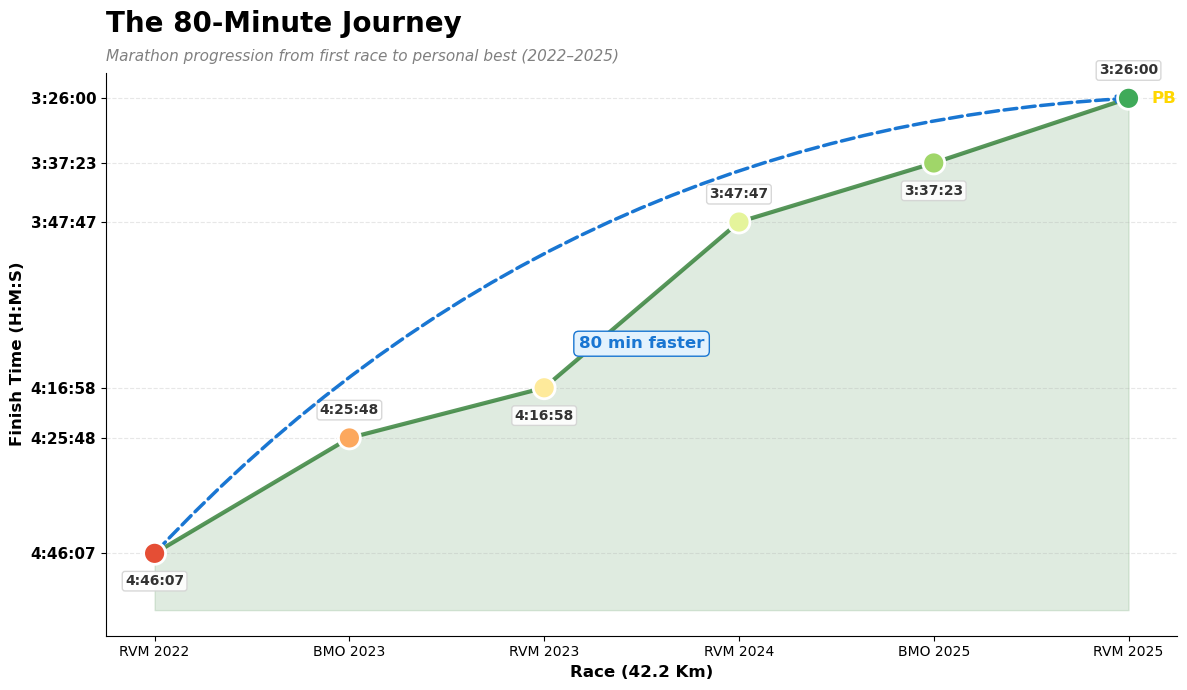

In [22]:
marathon_df["Race"] = ["RVM 2022", "BMO 2023", "RVM 2023", "RVM 2024", "BMO 2025", "RVM 2025"]

# Official times (H:MM:SS format for display)
marathon_df["Official Time"] = [
    "4:46:07",  # RVM 2022
    "4:25:48",  # BMO 2023
    "4:16:58",  # RVM 2023
    "3:47:47",  # RVM 2024
    "3:37:23",  # BMO 2025
    "3:26:00"   # RVM 2025
]

# Official times in seconds (for calculations/plotting)
marathon_df["Official Time (s)"] = [
    4*3600 + 46*60 + 7,   # 4:46:07
    4*3600 + 25*60 + 48,  # 4:25:48
    4*3600 + 16*60 + 58,  # 4:16:58
    3*3600 + 47*60 + 47,  # 3:47:47
    3*3600 + 37*60 + 23,  # 3:37:23
    3*3600 + 26*60 + 0    # 3:26:00
]

# Official times in minutes (for plotting)
marathon_df["Official Time (min)"] = marathon_df["Official Time (s)"] / 60

# Data to plot
races = marathon_df["Race"]
times = marathon_df["Official Time (min)"]
labels = marathon_df["Official Time"] 

# Color gradient for markers (red → green)
colors = plt.cm.RdYlGn(np.linspace(0.15, 0.85, len(races)))

# Create figure
plt.figure(figsize=(12, 7))

# Green fill under the line
plt.fill_between(races, times, max(times) + 10, alpha=0.15, color='#2E7D32', zorder=1)

# Plot Line 
plt.plot(races, times, color='#2E7D32', linewidth=3, alpha=0.8, zorder=2)

# Plot markers with gradient colors
plt.scatter(races, times, s=250, c=colors, zorder=5, edgecolor='white', linewidth=2)

# Add time labels to each point
for i, (race, time, label) in enumerate(zip(races, times, labels)):
    offset = -15 if i % 2 == 0 else 15  # Alternate above/below
    va = 'top' if i % 2 == 0 else 'bottom'
    plt.annotate(label, xy=(race, time), xytext=(0, offset), 
                 textcoords='offset points', ha='center', va=va,
                 fontsize=10, fontweight='bold', color='#333333',
                 bbox=dict(boxstyle='round,pad=0.2', facecolor='white', 
                          edgecolor='lightgray', alpha=0.9))

# Custom label for Y-axis (Official times in H:M:S format)
plt.yticks(times, labels, fontsize = 11, fontweight = "bold") 

# Invert Y-axis to show the fastest time at the top
plt.gca().invert_yaxis()

# Title and subtitle
plt.title("The 80-Minute Journey\n", fontsize=20, fontweight='bold', loc='left')
plt.text(0.0, 1.02, "Marathon progression from first race to personal best (2022–2025)", fontsize=11, color='gray', style='italic', transform=plt.gca().transAxes)

# Axis Labels
plt.xlabel("Race (42.2 Km)", fontsize = 12, fontweight = "bold")
plt.ylabel("Finish Time (H:M:S)", fontsize = 12, fontweight = "bold")

# Blue arrow 
plt.annotate('', xy=(5, times.iloc[-1]), xytext=(0, times.iloc[0]), arrowprops=dict(arrowstyle='->', linestyle = '--',color='#1976D2', lw=2.5, connectionstyle='arc3,rad=-0.2'))

# Improvement annotation
plt.annotate('80 min faster', xy=(2.5, 250), fontsize=12, fontweight='bold', color='#1976D2', ha='center', bbox=dict(boxstyle='round,pad=0.3', facecolor='#E3F2FD', edgecolor='#1976D2'))

# PB marker
plt.annotate('PB', xy=(5.12, times.iloc[-1]), fontsize=12, fontweight='bold', color='#FFD700', ha='left', va='center')

# Clean up spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Grid
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig('marathon_progression.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# Pace Evolution Curve

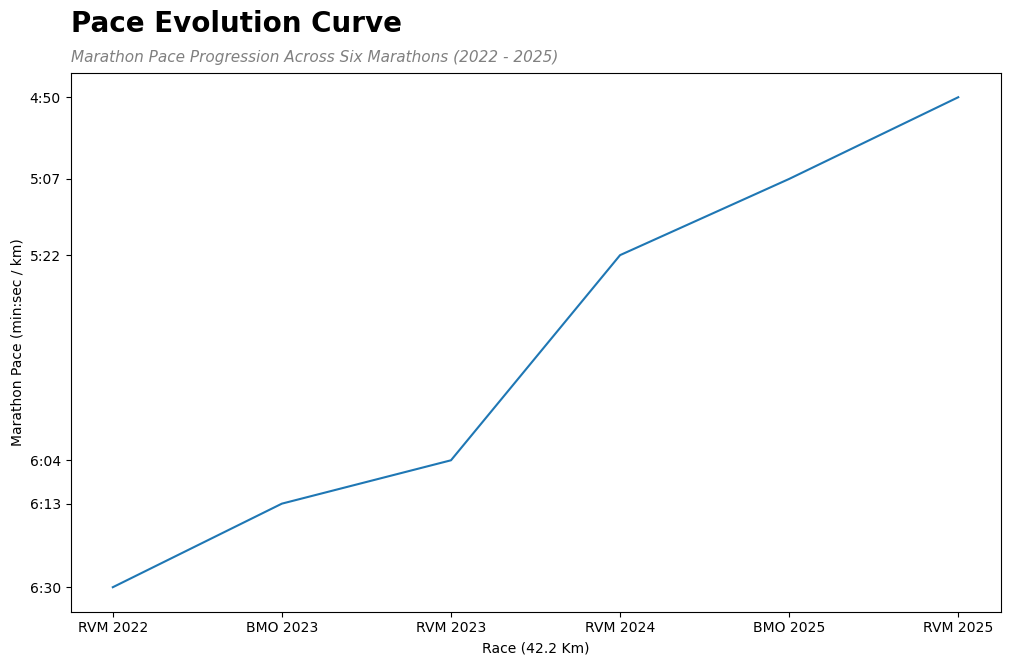

In [21]:
pace_to_plot = marathon_df["Pace (min/km)"]
pace_y_axis = marathon_df["Pace (min:sec/km)"]

plt.figure(figsize=(12, 7))
plt.plot(races, pace_to_plot)

# Title and subtitle
plt.title("Pace Evolution Curve\n", fontsize=20, fontweight='bold', loc='left')
plt.text(0.0, 1.02, "Marathon Pace Progression Across Six Marathons (2022 - 2025)", fontsize=11, color='gray', style='italic', transform=plt.gca().transAxes)


plt.xlabel("Race (42.2 Km)")
plt.ylabel("Marathon Pace (min:sec / km)")
plt.gca().invert_yaxis()
plt.yticks(pace_to_plot, pace_y_axis)
plt.show()

# Building the Base

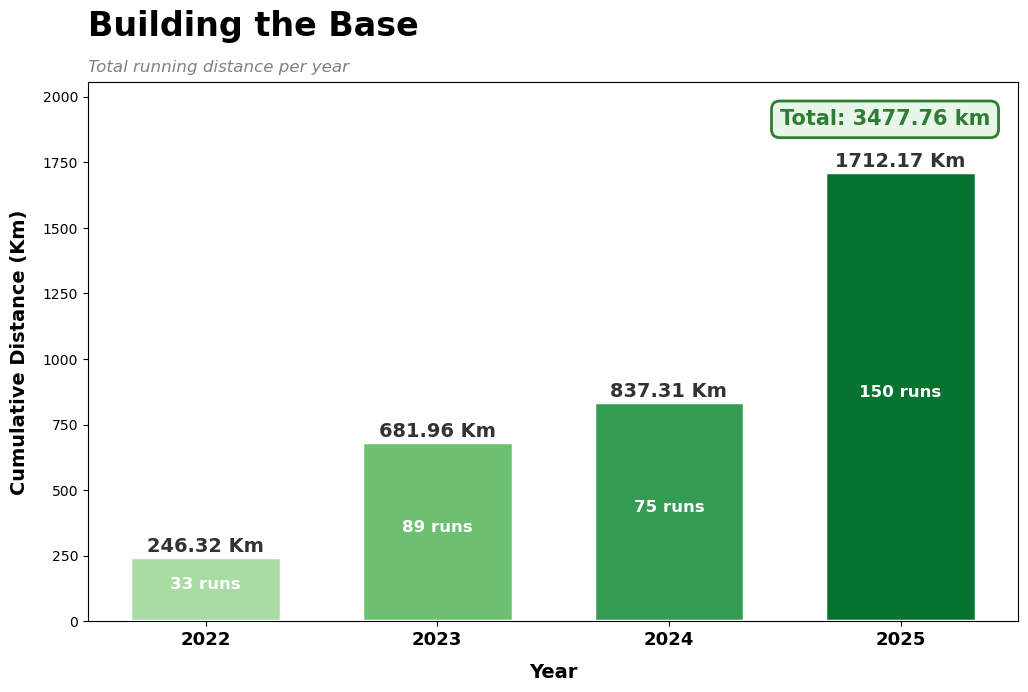

In [6]:
cumulative_distance_year_df = running_df.groupby("Year")["Distance (km)"].sum().reset_index()

# Data to plot
years = cumulative_distance_year_df["Year"].astype(int)
year_distance = cumulative_distance_year_df["Distance (km)"]
runs_per_year = running_df.groupby("Year").size().values

# Colors
colors = plt.cm.Greens(np.linspace(0.35, 0.85, len(years)))

# Create Figure
plt.figure(figsize=(12, 7))

# Get axis for more control
ax = plt.gca()

# Plot
plt.bar(years, year_distance, color=colors, edgecolor='white', linewidth=2.5, width=0.65)
plt.xticks(years, fontsize=13, fontweight='bold') # Whole Number Years
plt.xlabel("Year", fontsize=14, fontweight='bold', labelpad=10)
plt.ylabel("Cumulative Distance (Km)", fontsize=14, fontweight='bold', labelpad=10)

# Title and Subtitle
plt.title("Building the Base\n", fontsize=24, fontweight='bold', loc='left')
plt.text(0.0, 1.02, "Total running distance per year", fontsize=12, color='gray', style='italic', transform=plt.gca().transAxes)

# Set limits
plt.ylim(0, max(year_distance) * 1.20)

for i in range(len(years)):
    # Distance label on top of the bar
    plt.text(years[i], year_distance[i] + 20, (f"{round(year_distance[i],2)} Km"), ha = "center", fontsize=14, fontweight='bold', color='#333333')
    # Run Count inside the bar
    plt.text(years[i], year_distance[i] / 2, (f"{runs_per_year[i]} runs"), ha = "center", fontsize=12, fontweight='bold', color='white')

total_km = year_distance.sum()
plt.text(0.97, 0.95, f"Total: {total_km} km", transform=ax.transAxes, fontsize=15, fontweight='bold', color='#2E7D32', ha='right', va='top', bbox=dict(boxstyle='round,pad=0.4', facecolor='#E8F5E9', edgecolor='#2E7D32', linewidth=2))
plt.savefig('yearly_totals.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()